## Kaposの局所起伏幅の計算例
各位置（ピクセル）で半径7000m以内に300m以上の標高差があるかどうかを判定する。
ある場合は１，ない場合は０とする。
出力はGeotiffフォーマットとし、QIGSなどのGISソフトでも利用できることを考慮しました。


### モジュールのインポート
はじめに、今回の計算で必要なモジュールをインポートします。
行列計算を高速で行うために、今回はpandasではなくGPUを用いるCupyを使用しました。
私の環境（GPU:　GTX1070)　では計算時間は1/3程度になりました。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import rasterio

import json
import os
import glob

import time
from datetime import datetime
from dateutil.parser import parse

from tqdm import tqdm
from PIL import Image
import cv2

import folium

import json
from osgeo import gdal, osr, gdalconst, gdal_array 
import geopandas as gpd

import rasterio.mask


import cupy as cp

### 標高データ（DEM)の切り出し。
　日本全土の標高データを一度に処理することは負荷が大きいため、東北地方、九州地方の単位でデータを切り出しました。


　領域の切り出しは、領域の緯度・経度情報を以下のサイトから得ることができます。
 
 関心粋の選択（左の作成チールより四角を選択），ポリゴンを作成。その後”Show feature”をクリックしポリゴン情報を右枠に表示させ、Copyを押して情報をコピーします。

In [2]:
#関心領域のポリゴン情報の取得．
from IPython.display import HTML
HTML(r'<iframe width="1000" height="580" src="https://gispolygon.herokuapp.com/" frameborder="0"></iframe>')

右枠のポリゴン情報のすべてをコピーし，以下のAの右辺にペーストする．

In [3]:
A = {"type":"FeatureCollection","features":[{"properties":{"note":"","distance":"671838.01 m","drawtype":"rectangle","area":"4568286.07 ha"},"type":"Feature","geometry":{"type":"Polygon","coordinates":[[[139.30183410644534,41.343824581185714],[139.30183410644534,43.54058479482877],[141.57600402832034,43.54058479482877],[141.57600402832034,41.343824581185714],[139.30183410644534,41.343824581185714]]]}}]}

In [4]:
#今後使用する任意のファイル名をセットする． 例えば，地域の名前など．
object_name = 'Japan_w-hokkaido2_90m'

In [5]:
with open(str(object_name) +'_2.geojson', 'w') as f:
    json.dump(A, f)

In [6]:
json_file = open(str(object_name) +'_2.geojson')
json_object = json.load(json_file)
AREA = json_object["features"][0]["geometry"]['coordinates'][0]
area = pd.DataFrame(AREA,
                  columns=['longtitude', 'latitude'])
area_d =[[area['longtitude'].min(), area['latitude'].max()],
 [area['longtitude'].max(), area['latitude'].max()],
 [area['longtitude'].max(), area['latitude'].min()],
 [area['longtitude'].min(), area['latitude'].min()],
 [area['longtitude'].min(), area['latitude'].max()]]

AREA = area_d

以下を実行し、切り出した領域を確認します。間違えていた場合は、上記の関心域の作成から再度試してください。

In [7]:
m = folium.Map([(AREA[0][1]+AREA[2][1])/2,(AREA[0][0]+AREA[2][0])/2], zoom_start=9)

folium.GeoJson(str(object_name) +'_2.geojson').add_to(m)
m

### DEMデータの読み込み。
　日本全土の90m分解能のDEMデータ（SRTM)を以下のサイトからダウンロードします。
 
 複数に分割されている場合は、QGISなどのGISソフトにて結合（merge)して一つのファイル（geotiff)にしてください。
 
 https://cgiarcsi.community/data/srtm-90m-digital-elevation-database-v4-1/


In [8]:
# 画像ファイルの取得
file_path = './dem_data/' #ダウロードしたdemファイルの保存先を指定。
files =os.listdir(file_path)
files.sort()
files

['dem_srtm_japan.tif']

In [9]:
i=0
path_c = glob.glob(file_path + files[i])
imgA = path_c[0]　#DEMファイルのアドレスを設定

In [10]:
nReserve_geo = gpd.read_file(str(object_name) +'_2.geojson')
epsg = 'epsg:4326'
nReserve_proj = nReserve_geo.to_crs({'init': epsg})

/home/nigo/anaconda3/envs/GIS/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


関心域（AREA)をDEM画像から切り出します。

In [11]:
 with rasterio.open(imgA) as src:
    out_image, out_transform = rasterio.mask.mask(src, nReserve_proj.geometry,crop=True)
    out_meta = src.meta.copy()
    out_meta.update({"driver": "GTiff",
                    "height": out_image.shape[1],
                    "width": out_image.shape[2],
                    "transform": out_transform})

In [12]:
with rasterio.open('./' +str(object_name) +'_dem.tif', "w", **out_meta) as dest:
        dest.write(out_image)

切り出したDEM画像（今回は、北海道西部）を確認します。

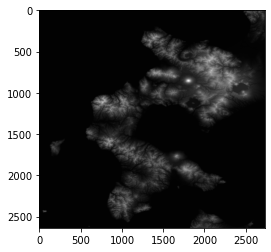

In [13]:
with rasterio.open('./' +str(object_name) +'_dem.tif') as src:
      arr = src.read()

plt.imshow(arr[0], cmap='gray')

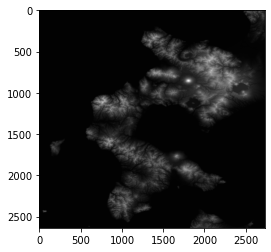

In [14]:
img_test = arr[0].copy()
img_test =np.where(img_test== -32768, 0, img_test)
plt.imshow(img_test, cmap='gray')

In [15]:
img = arr[0]
h, w = img.shape

In [16]:
#切り出したDEM画像のサイズを確認
print(h)
print(w)

2637
2730


In [17]:
#画像サイズを小さくすることで計算時間の短縮を試みる。

t = 1 #　ｔ分の1サイズにする。90m分解能を270m分解能にするのであれば、tを3とする。
img_resize = cv2.resize(img, (int(w / t), int(h / t)), interpolation=cv2.INTER_CUBIC)

In [18]:
img_resize.shape

(2637, 2730)

In [19]:
#画像のResize後のサイズを確認
h, w = img_resize.shape
print(h)
print(w)

2637
2730


ダウンロードしたSRTM画像の解像度などの情報は以下をご参考ください。

SRTM 5deg = 90m resolution

https://cgiarcsi.community/data/srtm-90m-digital-elevation-database-v4-1/#:~:text=Digital%20elevation%20models%20(DEM)%20for,for%20easy%20download%20and%20use.

In [20]:
#切り出した画像データをGPUで処理するための、cupy形式に変換します。
img_resize_cp = cp.asarray(img_resize)

半径7000m以内の標高値を得るために、7000mに相当するピクセル数を求めます。

In [21]:
n = 90 #90m resolution
radius = int(7000/n/t) #画像サイズがt分の１になったので、radiusのピクセル数も変更する。

### 局所起伏幅の算出
計算方法は以下となります。

・半径7000mのマスク画像を作成。
・任意位置（ピクセル）のDEMデータより、上記で作成したマスク画像で切り出す（Crip)。
・任意位置と標高値と切り出したDEM画像内の最大標高差（プラス、マイナス）を求める。
・求めた最大標高差が300mより大きければ１を出力、３００m以下であれば０を出力する。
・この計算は、DEMデータのすべての位置（ピクセル）で行う。例えば、DEMデータの画素数が10000x1000であれば、1000000回の計算となる。

In [22]:
test_w = []

for v in tqdm(range(h)):
    for i in range(w):
        # マスク作成 (黒く塗りつぶす画素の値は0)
        mask = np.zeros((h, w), dtype=np.uint8)
         # 円を描画する関数 circle() を利用してマスクの残したい部分を 255 にしている。
        cv2.circle(mask, center=(i, v), radius=radius, color=255, thickness=-1)
                   
        img2 = img_resize_cp.copy() #画像の読み込み
        img2 = cp.where(img2== -32768, 0, img2) #海は海抜０mとする。
        img2[mask==0] = [0]  # mask の値が 0 の画素は黒で塗りつぶす。
        result = img2.max() - img2[v][i] #読み出したピクセル位置から半径7000m以内の最大高度との差分を取得
        if img2.max() == 0: #DEMがすべて０となると，nonzeroが０のみのため出力がなくなりエラーとなる．
            result2 = 0 
        else:
            result2 = img2[v][i] - cp.min(img2[cp.nonzero(img2)]) #読み出したピクセル位置より一番低い高度との差分を取得
        if result > 300 or result2 > 300:
            test = 1
        else:
            test = 0
        test_w.append(test)
    

100%|██████████| 2637/2637 [22:33:02<00:00, 30.79s/it]   


計算結果を画像データとして扱うために、cupy形式からnumpy形式に変換する。

In [23]:
test2A = np.array(test_w)

In [24]:
test_dem =test2A.reshape(h, w)

出力データのサイズ（画素数）の確認。切り出したDEMデータのサイズと同じであることを確認する。

In [25]:
print(test_dem.shape[0])
print(test_dem.shape[1])

2637
2730


出力データを画像で確認。

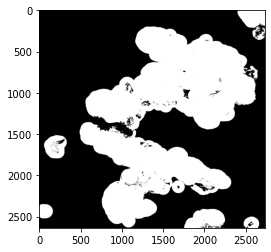

In [26]:
plt.imshow(test_dem, cmap='gray')

In [27]:
#切り出したdem画像の保存

with rasterio.open('./results/' +str(object_name) +'_dem.tif', "w", **out_meta) as dest:
        dest.write(out_image)

出力データをGeotiffに出力するために、切り出したDEMデータの位置情報を取得する。

In [28]:
#空間参照系の読み込み

src = gdal.Open('./' +str(object_name) +'_dem.tif', gdalconst.GA_ReadOnly) # tifの読み込み (read only)
type(src) # "osgeo.gdal.Dataset"

print(src.RasterXSize) # 水平方向ピクセル数
print(src.RasterYSize) # 鉛直方向ピクセル数

print(src.GetGeoTransform()) # 座標に関する６つの数字 (下記参照)
print(src.GetProjection()) # 座標系情報

geotransform = src.GetGeoTransform()

2730
2637
(139.30166666666668, 0.0008333333333333334, 0.0, 43.54083333333333, 0.0, -0.0008333333333333334)
GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]


出力データに位置情報を付与してGeotiffフォーマットで出力する。

In [29]:
#Geotiffで出力。
from osgeo import osr # 空間参照モジュール

dtype = gdal.GDT_Float32 #others: gdal.GDT_Byte, ...GDT_Float32
band = 1 # バンド数

xsize = test_dem.shape[0]
ysize = test_dem.shape[1]

output = gdal.GetDriverByName('GTiff').Create('./results/' + str(object_name) + '_local_elevation_range_300m.tif', ysize, xsize, band, dtype) # 作成したファイルの保存先を指定。MyDrive以下が、Google Driveの指定ディレクトリ

output.SetGeoTransform((geotransform[0], geotransform[1]*t, geotransform[2], geotransform[3], geotransform[4], geotransform[5]*t)) # 座標系指定
srs = osr.SpatialReference() # 空間参照情報
srs.ImportFromEPSG(4326) # WGS84 UTM_48nに座標系を指定
output.SetProjection(srs.ExportToWkt()) # 空間情報を結合

output.GetRasterBand(1).WriteArray(test_dem)   # test_dem書き出し（b1はnumpy 2次元配列）
output.FlushCache()                     # ディスクに書き出し
output = None  